# Download Data with `earthaccess`

## STEP 1: Set up

Load your stored variables into memory:

In [1]:
%store -r denver_redlining_gdf data_dir

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import packages</div></div><div class="callout-body-container callout-body"><p>Add imports for packages that help you:</p>
<ol type="1">
<li>Work with the file system interoperably</li>
<li>Work with vector data</li>
<li>Create interactive plots of vector data</li>
<li>Group and aggregate tabular data</li>
</ol></div></div>

In [2]:
import re # Use regular expressions to extract metadata

import earthaccess # Access NASA data from the cloud
import matplotlib as plt # Overlay raster and vector data
import numpy as np # Process bit-wise cloud mask
import pandas as pd # Group and aggregate
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Set up `earthaccess` connection</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Make an account on the <a
href="https://urs.earthdata.nasa.gov/">earthdata site</a>. You don’t
need to spend a lot of time on the registration form – go ahead answer
their questions to the best of your ability. That information is used
for internal reporting and analysis, not to decide whether or not to
grant you an account!</li>
<li>Run the code below an enter your credentials to log into earthaccess
from Python. You should only need to do this once, as long as
<code>persist=True</code> is set.</li>
</ol></div></div>

In [3]:
earthaccess.login(strategy="interactive", persist=True)

## STEP 2: Search

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Search for HLS data</div></div><div class="callout-body-container callout-body"><p>It can be useful to use NASA’s online resources to find the data you
want to download before accessing it over API. To do that:</p>
<ol type="1">
<li>Go to the <a href="https://worldview.earthdata.nasa.gov/">NASA
Worldview Site</a> and search for Denver, CO.</li>
<li>Add the <code>HLSL30</code> product as a base map. You can do this
by clicking <code>Add Layer</code> and then searching for the
<strong>short name</strong> <code>HLSL30</code>. When looking for other
datasets, the short name can usually be found by on the data homepage,
accessible from the <strong>doi</strong>. Practice opening the data page
for <code>HLSL30</code> to find where the shortcode is.</li>
<li>By dragging the date indicator on the bottom, search the month of
July, 2023 for a day that has data available and little to no cloud
cover over Denver. You may need to wait a second or so for the data to
load for any given date.</li>
</ol>
<p>Now, using the code below:</p>
<ol type="1">
<li>Put the short name of the dataset into the
<code>earthaccess.search_data()</code> function.</li>
<li>Replace <code>gdf</code> with the name of your denver redlining
<code>GeoDataFrame</code>.</li>
<li>Put the date you found into the <code>temporal</code> parameter,
replacing <code>YYYY-MM-DD</code> with the appropriate year (Y), month
(M), and day (D) digits.</li>
<li>Run the code and make sure there are results! If not, double check
your date.</li>
</ol></div></div>

In [4]:
denver_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(denver_redlining_gdf.total_bounds),
    temporal=("2023-07-12"),
    count=1
)
denver_results

[Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.84822916, 'Latitude': 38.7577866}, {'Longitude': -104.88766444, 'Latitude': 38.76081048}, {'Longitude': -104.88607437, 'Latitude': 39.75021202}, {'Longitude': -105.55700976, 'Latitude': 39.74893151}, {'Longitude': -105.84822916, 'Latitude': 38.7577866}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-07-12T17:36:53.600Z', 'EndingDateTime': '2023-07-12T17:37:17.491Z'}}
 Size(MB): 132.62681674957275
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.B04.tif', 'https://dat

## STEP 3: Open data connections

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Access HLS data</div></div><div class="callout-body-container callout-body"></div></div>


In [5]:
denver_files = earthaccess.open(denver_results)

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

## STEP 4: Process data

### Connect with Python

Right now, you have **file connections** with your data in the cloud,
but you haven’t actually downloaded anything. `earthaccess` uses a
**lazy** virtual file connection (vsi), meaning that it doesn’t download
anything until you ask for specific numbers, like when you plot. In
addition, many operations can be performed on the server side, such as
selecting data by index and summary operations.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Practice importing multispectral data</div></div><div class="callout-body-container callout-body"><p>To load in the green band of data to work with them:</p>
<ol type="1">
<li><strong>Find a green layer:</strong> Check out the <a
href="https://hls.gsfc.nasa.gov/wp-content/uploads/2019/01/HLS.v1.4.UserGuide_draft_ver3.1.pdf">HLSL30
User Guide</a>. Which layer is the green layer? What is its
<strong>index</strong> in the list of files you got from
<code>earthaccess</code>? Remember that Python starts counting at
0!</li>
<li><strong>Open the layer:</strong> Open one of <strong>green</strong>
layers you downloaded using the <code>rxr.open_rasterio()</code>
function. You can do this by index if you like – this code is for you to
explore using the data. Don’t forget to <code>.squeeze()</code>! But,
hold off on masking and scaling so you can see what it looks like to
have unmasked nodata values in your <code>DataArray</code>.</li>
<li><strong>Mask nodata values and apply the scale factor:</strong> Now,
plot your Data Array. Notice that many of the values are somewhere
around -10000. We can guess, because it’s common in datasets like this,
that the value -9999 is used here as a “no data” value to mark where no
measurement was taken. To encode the no data values correctly, add the
parameter <code>mask_and_scale=True</code> to the
<code>rxr.open_rasterio()</code> function. Now, the image should be
white where there’s no data, the values should range between 0 and
1.</li>
<li>Try out your file connection to see how long different operations
take. You can try taking the <code>.mean()</code> of your data (fast –
this happens on the server), and plotting your data (slow – you have to
download the whole tile to plot this way). Next, add the study boundary
onto the image. Notice that you have quite a bit more data than you
need!</li>
</ol></div></div>

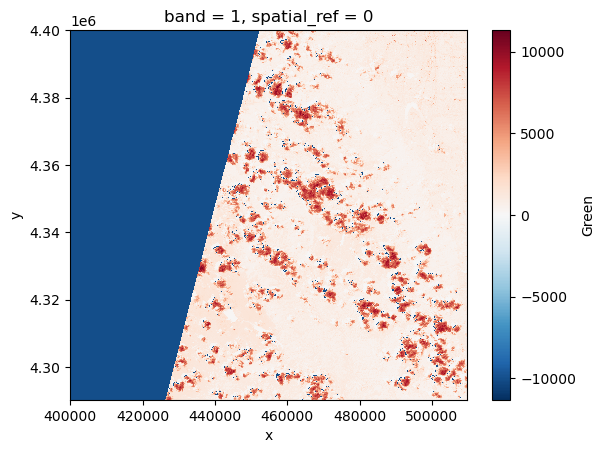

In [6]:
# Import one tile of green data
green_da = rxr.open_rasterio(denver_files[8], mask_and_scake=True).squeeze()
green_da.plot()

In [7]:
# Import one tile of blue data
blue_da = rxr.open_rasterio(denver_files[4]).squeeze()
blue_da

<xarray.DataArray (y: 3660, x: 3660)> Size: 27MB
[13395600 values with dtype=uint16]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 29kB 4.4e+06 4.4e+06 4.4e+06 ... 4.29e+06 4.29e+06
    spatial_ref  int64 8B 0
Attributes:
    add_offset:          0.0
    L1T_SceneID:         2023-07-12_033032_SZA.img;2023-07-12_033033_SZA.img
    OVR_RESAMPLING_ALG:  NEAREST
    scale_factor:        0.01
    AREA_OR_POINT:       Area
    _FillValue:          40000

### Crop

Plotting a whole HLSL30 tile probably took about 30 seconds to download
and plot the data, but we know that some operations can be performed
without downloading. One of this is **cropping** the raster image by
index using the `.rio.clip_box()` method. Note that `.rio.clip()` clips
the data to a boundary instead of a rectangle, and will trigger a full
download.

We almost always want to crop before doing *anything* else. Cropping
usuallyreduces the amount of data you need dramatically, which makes
everything faster.

In this example, our study area vector data and our raster multispectral
reflectance data come in different **Coordinate Reference System**s
(CRSs). Before using them together, you will need to convert the vector
data to be in the same CRS as the raster data.

> **Why convert vector data?**
>
> You’re being asked to convert vector data to the raster CRS instead of
> the other way around for two specific reasons. One is that vector data
> is usually smaller than raster data and converts faster. The other is
> that converting the CRS of a raster file means that the centers of the
> grid cells will be in slightly different locations because grids do
> not transfer over. This requires some kind of **interpolation**, which
> can be computationally costly and also have the potential to introduce
> error.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Get your study bounds</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Access the CRS of the redlining data (<code>.crs</code>) and the
reflectance data (<code>.rio.crs</code>) to verify that they are not the
same</li>
<li>Convert the redlining <code>GeoDataFrame</code> to the same CRS as
the reflectance data.</li>
<li>Get the <code>.total_bounds</code> of the redlining data so you can
crop to it.</li>
</ol></div></div>

In [8]:
# Get the study bounds
denver_bounds = (
    denver_redlining_gdf
    .to_crs(green_da.rio.crs)
    .total_bounds
)
denver_bounds

array([ 494666.8440201 , 4386638.95096192,  510602.89174258,
       4404573.87473628])

Now, you’re ready to crop.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Crop raster data</div></div><div class="callout-body-container callout-body"><p>To crop your data, use the method
<code>.rio.clip_box(*your_bounds_here)</code>.</p>
<p>The asterisk <strong>unpacks</strong> the bounds so that they go in
as four separate arguments instead of a single tuple.</p>
<p>You can also practice cloud masking again here if you like. Note that
you will also need to crop your cloud mask!</p></div></div>

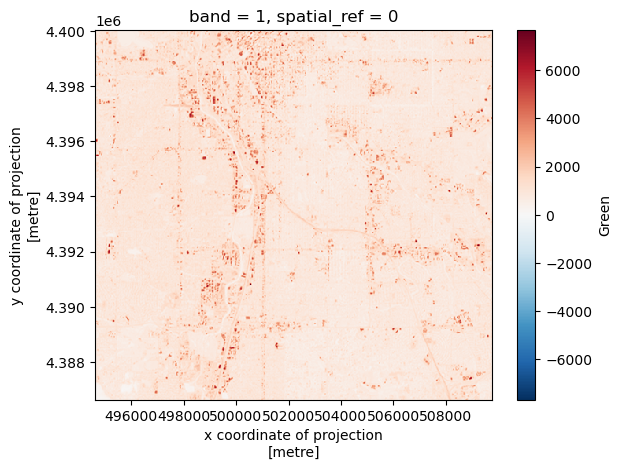

In [9]:
# Crop the green reflectance data
green_da = green_da.rio.clip_box(*denver_bounds)
green_da.plot()

Congratulations – you’ve accessed some data from the cloud!